In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mental-health-conversational-data/intents.json


# Reading Data

In [2]:
import json

with open(r'/kaggle/input/mental-health-conversational-data/intents.json') as f:
    data = json.load(f)

df = pd.DataFrame(data['intents'])

In [3]:
df

,tag,patterns,responses
0,greeting,"[Hi, Hey, Is anyone there?, Hi there, Hello, H...",[Hello there. Tell me how are you feeling toda...
1,morning,[Good morning],[Good morning. I hope you had a good night's s...
2,afternoon,[Good afternoon],[Good afternoon. How is your day going?]
3,evening,[Good evening],[Good evening. How has your day been?]
4,night,[Good night],"[Good night. Get some proper sleep, Good night..."
...,...,...,...
75,fact-28,[What do I do if I'm worried about my mental h...,[The most important thing is to talk to someon...
76,fact-29,[How do I know if I'm unwell?],"[If your beliefs , thoughts , feelings or beha..."
77,fact-30,[How can I maintain social connections? What i...,"[A lot of people are alone right now, but we d..."
78,fact-31,[What's the difference between anxiety and str...,[Stress and anxiety are often used interchange...


Each tag contain multiple questions & answers so i want to sprate them 

In [4]:
dic = {"tag":[], "patterns":[], "responses":[]}
for i in range(len(df)):
    ptrns = df[df.index == i]['patterns'].values[0]
    rspns = df[df.index == i]['responses'].values[0]
    tag = df[df.index == i]['tag'].values[0]
    for j in range(len(ptrns)):
        dic['tag'].append(tag)
        dic['patterns'].append(ptrns[j])
        dic['responses'].append(rspns)

In [5]:
df = pd.DataFrame.from_dict(dic)

# Data Preprocessing

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(lower=True, split=' ')
tokenizer.fit_on_texts(df['patterns'])
tokenizer.get_config()

vacab_size = len(tokenizer.word_index)
print('number of unique words = ', vacab_size)

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

ptrn2seq = tokenizer.texts_to_sequences(df['patterns'])
X = pad_sequences(ptrn2seq, padding='post')
print('X shape = ', X.shape)

lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(df['tag'])
print('y shape = ', y.shape)
print('num of classes = ', len(np.unique(y)))

number of unique words =  303
X shape =  (232, 18)
y shape =  (232,)
num of classes =  80


Now i am going to build and train model


2023-02-22 07:24:59.178936: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64::/opt/conda/lib
2023-02-22 07:24:59.179002: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 100)           30400     
                                                                 
 lstm (LSTM)                 (None, 18, 32)            17024     
                                                                 
 layer_normalization (LayerN  (None, 18, 32)           64        
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 18, 32)            8320      
                                                                 
 layer_normalization_1 (Laye  (None, 18, 32)           64        
 rNormalization)                                                 
                                                                 
 lstm_2 (LSTM)               (None, 32)                8

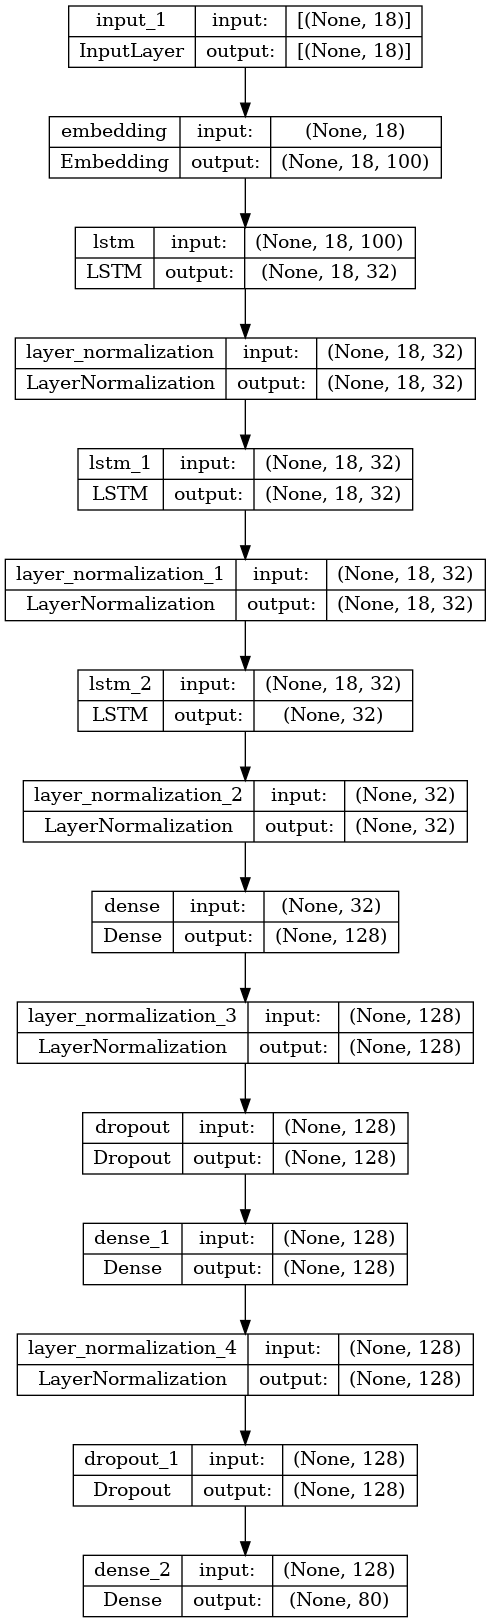

In [7]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, LayerNormalization, Dense, Dropout
from tensorflow.keras.utils import plot_model

model = Sequential()
model.add(Input(shape=(X.shape[1])))
model.add(Embedding(input_dim=vacab_size+1, output_dim=100, mask_zero=True))
model.add(LSTM(32, return_sequences=True))
model.add(LayerNormalization())
model.add(LSTM(32, return_sequences=True))
model.add(LayerNormalization())
model.add(LSTM(32))
model.add(LayerNormalization())
model.add(Dense(128, activation="relu"))
model.add(LayerNormalization())
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(LayerNormalization())
model.add(Dropout(0.2))
model.add(Dense(len(np.unique(y)), activation="softmax"))
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

model.summary()
plot_model(model, show_shapes=True)

In [8]:
model_history = model.fit(x=X,
                          y=y,
                          batch_size=10,
                          callbacks=[tensorflow.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)],
                          epochs=30)

Epoch 1/30
24/24 [==============================] - 15s 40ms/step - loss: 4.9003 - accuracy: 0.0216
Epoch 2/30
24/24 [==============================] - 1s 40ms/step - loss: 3.7895 - accuracy: 0.1207
Epoch 3/30
24/24 [==============================] - 1s 39ms/step - loss: 3.1118 - accuracy: 0.2629
Epoch 4/30
24/24 [==============================] - 1s 40ms/step - loss: 2.5888 - accuracy: 0.3922
Epoch 5/30
24/24 [==============================] - 1s 40ms/step - loss: 2.1493 - accuracy: 0.4914
Epoch 6/30
24/24 [==============================] - 1s 40ms/step - loss: 1.7882 - accuracy: 0.5603
Epoch 7/30
24/24 [==============================] - 1s 40ms/step - loss: 1.4888 - accuracy: 0.6207
Epoch 8/30
24/24 [==============================] - 1s 41ms/step - loss: 1.2347 - accuracy: 0.6983
Epoch 9/30
24/24 [==============================] - 1s 39ms/step - loss: 1.1008 - accuracy: 0.7414
Epoch 10/30
24/24 [==============================] - 1s 42ms/step - loss: 0.8679 - accuracy: 0.8147
Epoch 11

Now i am going to test Model

In [9]:
import re
import random

def model_responce(query): 
    text = []
    txt = re.sub('[^a-zA-Z\']', ' ', query)
    txt = txt.lower()
    txt = txt.split()
    txt = " ".join(txt)
    text.append(txt)
        
    x_test = tokenizer.texts_to_sequences(text)
    x_test = np.array(x_test).squeeze()
    x_test = pad_sequences([x_test], padding='post', maxlen=X.shape[1])
    y_pred = model.predict(x_test)
    y_pred = y_pred.argmax()
    tag = lbl_enc.inverse_transform([y_pred])[0]
    responses = df[df['tag'] == tag]['responses'].values[0]

    print("you: {}".format(query))
    print("model: {}".format(random.choice(responses)))